# A1: Linear Model with Nonlinear Inputs

Name: Ivan Morrow

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# Sine Transform

As we have seen in our recent lecture notes, the air quality data shows variations in CO with time of day.  We have used linear models and simple nonlinear models based on polynomial transformations of the input variable, the hour of the day.

In this assignment, you will explore transformations of the input variable using a sine function.  You will use the sine function

$$ y(x) = \sin(shift + scale\cdot x)$$

where the values of $shift$ and $scale$ control the translation and frequency of the sine function.  Notice that if $x$ is $N\times 1$, a matrix containing $N$ samples each with 1 component, or dimension, and $shift$ and $scale$ are both $1\times S$, matrices containing 1 row and shifts and scales for $S$ different sine functions, then $y(x)$ will be $N\times S$.

With `shifts` and `scales` being equal length lists or vectors, we can transform samples in `X` having one column into multiple columns that are different sine functions applied to each sample.

For example, if $x \in (0, 23)$ representing the hour of the day, several sine functions for different values of $shift$ and $scale$ are shown below.  

In [7]:
def sine_transform(X, shifts, scales):
    return np.sin(shifts + scales * X)

Let's define a sine with a shift of 10 and scale of 3.  What would that look like?

In [10]:
# Xsines holds numpy array w/ 500 results of the sine function defined above
Xsines = sine_transform(X, 10, 3)
X.shape, Xsines.shape

((500, 1), (500, 1))

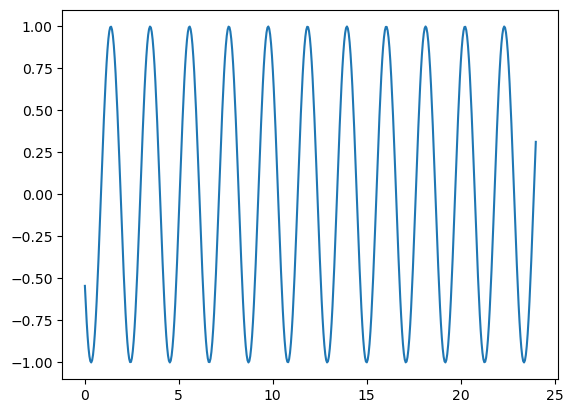

In [11]:
plt.plot(X, Xsines)

Let's anticipate a possible edge case.  What if at some stage we request a model with no sine functions?  This would just be a model having a single weight for the y-intercept.  We can handle this case if `sine_transform` checks the length of the shifts list.  If its length is 0, just return None.

Now define two sine transforms, one with shift of 10 and scale of 1 and a second one with shift of 5 and scale of 2. Remember, shift and scale must be a one-dimensional row vector, or a list because numpy will use a list as if it is a row vector.

In [14]:
# Here we are specifying two different sine functions.
shifts = [10, 5]
scales = [1, 2]

# Apply each sine function to the 500 samples in X.
Xs = np.linspace(0, 24, 500).reshape(-1, 1)
X_sines = sine_transform(Xs, shifts, scales)
X_sines.shape

(500, 2)

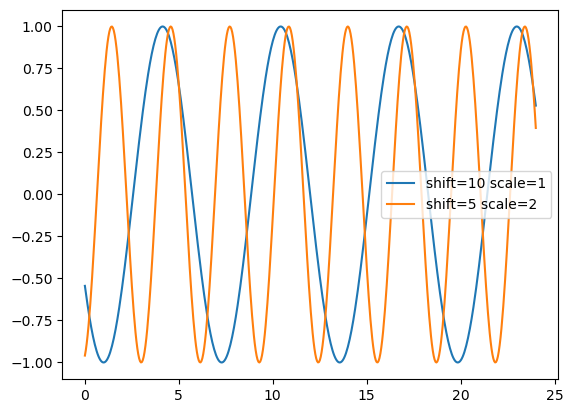

In [15]:
for i in range(X_sines.shape[1]):  # number of columns
    plt.plot(Xs, X_sines[:, i], label=f'shift={shifts[i]} scale={scales[i]}')
plt.legend();

# Nonlinear model based on sine transform and our previous linear model.

In [17]:
"""
Extracts first item from weights W as y-intercept
Performs mat mul b/t X_sines and rest of W (weights)
"""
def sine_model(X_sines, W):
    y = W[0] + X_sines @ W[1:]
    return y                   

(500, 3) (4, 1)


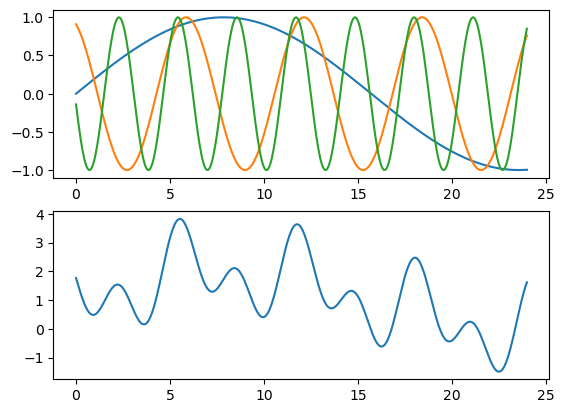

In [18]:
shifts = [0, 2, -3]
scales = [0.2, 1, 2]
W = np.ones((len(shifts) + 1, 1))

X = np.linspace(0, 24, 500).reshape(-1, 1)
Xsines = sine_transform(X, shifts, scales)
print(Xsines.shape, W.shape)

plt.subplot(2, 1, 1)
plt.plot(X, Xsines)
plt.subplot(2, 1, 2)
Y = sine_model(Xsines, W)
plt.plot(X, Y);

# Finding best sine function shifts and scales and best weights W

To train our model with sine functions as inputs we will need the following functions, copies from lecture notes.

In [21]:
def model(X, W):
    return W[0, :] + X @ W[1:, :]

def dYdW(X):
    return np.insert(X, 0, 1, axis=1)

#Gradient of E with respect to Y
def dEdY(Y, T):
    return -2 * (T - Y)
    
# Gradient of E with respect to W.
def dEdW(X, T, Y):
    result = dEdY(Y, T).T @ dYdW(X) / X.shape[0]
    return result.T

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

Now we can test these functions.

In [23]:
X = np.linspace(0, 24, 10).reshape(-1, 1)
T = np.arange(10).reshape(-1, 1)

np.hstack((X, T))

array([[ 0.        ,  0.        ],
       [ 2.66666667,  1.        ],
       [ 5.33333333,  2.        ],
       [ 8.        ,  3.        ],
       [10.66666667,  4.        ],
       [13.33333333,  5.        ],
       [16.        ,  6.        ],
       [18.66666667,  7.        ],
       [21.33333333,  8.        ],
       [24.        ,  9.        ]])

In [24]:
shifts = [0, 2, -3]
scales = [0.2, 1, 2]
W = np.zeros((len(shifts) + 1, 1))
Xsines = sine_transform(X, shifts, scales)
Y = model(Xsines, W)

print(f'{rmse(Y, T)=:.3f}')
print(f'{dEdY(Y, T).shape=}')
print(f'{dYdW(Xsines).shape=}')
print(f'{dEdW(Xsines, T, Y).shape=}')

rmse(Y, T)=5.339
dEdY(Y, T).shape=(10, 1)
dYdW(Xsines).shape=(10, 4)
dEdW(Xsines, T, Y).shape=(4, 1)


Use the batch version of `adamw` optimization function to find the best weights `W`, given sine transformed inputs `Xsines`.

In [26]:
"""
model_f (func): function defining our model
X (numpy array): numpy array representing input data (hour of day)
T (numpy array): numpy array representing target data (CO levels)
learning_rate (float): magnitude to adjust our weights by during training
n_epochs (int): num of training iterations to run, adjusting model weights each epoch

"""
def adamw(model_f, X, T, learning_rate, n_epochs):

    # Initialize weights (see https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)
    
    n_inputs = X.shape[1]
    W = np.random.uniform(-1, 1, size=(1 + n_inputs, 1)) / np.sqrt(n_inputs)

    # Initialize adamw parameters
    beta1 = 0.9
    beta2 = 0.99
    epsilon = 1e-8
    W_decay_rate = 0.0  # no weight decay, so really this is just the adam algorithm
    m = 0
    v = 0

    error_sequence = []
    for epoch in range(n_epochs):
    
        Y = model_f(X, W)  # not using the n:n+1 to select just one sample. Using them all.        
        gradient = dEdW(X, T, Y)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * gradient * gradient
        mhat = m / (1 - beta1 ** (epoch + 1))
        vhat = v / (1 - beta2 ** (epoch + 1))
        W -= learning_rate * mhat / (np.sqrt(vhat) + epsilon) + W_decay_rate * W

        error_sequence.append(rmse(Y, T))

    return W, error_sequence

Let's apply this to the `AirQualityUCI.csv` data we used in recent lectures.

In [28]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]  # This line added August 28th, 12:54 pm
data = data.dropna(axis=0)

hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
Xnames = ['Hour']

CO = data['CO(GT)']
T = CO
T = np.array(T).reshape((-1, 1))  # make T have one column and as many rows as needed to hold the values of T
Tnames = ['CO']

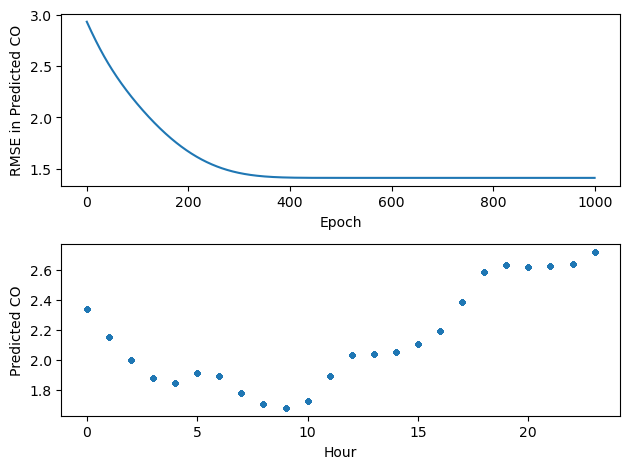

In [29]:
shifts = [0, 2, -3]
scales = [0.2, 1, 2]
Xsines = sine_transform(X, shifts, scales)

learning_rate = 0.01
n_epochs = 1000
W, error_sequence = adamw(model, Xsines, T, learning_rate, n_epochs)

plt.subplot(2, 1, 1)
plt.plot(error_sequence)
plt.xlabel('Epoch')
plt.ylabel('RMSE in Predicted CO')

plt.subplot(2, 1, 2)
Y = model(Xsines, W)
plt.plot(X, Y, '.')
plt.xlabel('Hour')
plt.ylabel('Predicted CO')
plt.tight_layout();

Now we can use these functions to illustrate how to find the best values for `shifts` and `scales`.  Do so by repeatedly choosing random values of `shifts` and `scales` for five sine functions. Use the `adamw` function to train a model for each set of sine functions, calculate the RMSE of the model's prediction of CO.

Here use `shift` values randomly chosen between  $-10$ and 10 and `scale` values randomly chosen between 0 and 2.  

In [31]:
shift_range = (-10, 10)  # these could be lists, rather than tuples
scale_range = (0, 2)

n_sine_functions = 5
n_repetitions = 10

for repetition in range(10):
    shifts = np.random.uniform(shift_range[0], shift_range[1], n_sine_functions)
    scales = np.random.uniform(scale_range[0], scale_range[1], n_sine_functions)
    Xsines = sine_transform(X, shifts, scales)
    
    learning_rate = 0.01
    n_epochs = 1000
    W, error_sequence = adamw(model, Xsines, T, learning_rate, n_epochs)

    error = rmse(model(Xsines, W), T)
    with np.printoptions(precision=3):
        print(f'Rep {repetition} RMSE={error:.2f} shifts {shifts} scales {scales}')

Rep 0 RMSE=1.24 shifts [ 0.203 -6.703 -7.611  1.371 -2.183] scales [0.058 0.423 0.692 0.329 0.034]
Rep 1 RMSE=1.28 shifts [ 8.175  2.345  0.343  7.188 -6.017] scales [1.966 0.254 0.592 1.882 0.233]
Rep 2 RMSE=1.34 shifts [-3.811 -3.602  4.575 -8.086  4.002] scales [1.171 1.512 0.13  1.02  1.714]
Rep 3 RMSE=1.34 shifts [-6.264 -9.884 -2.466  6.297 -6.245] scales [0.559 1.866 1.717 1.826 0.878]
Rep 4 RMSE=1.32 shifts [-1.606  1.824  2.474  6.317  6.302] scales [1.99  0.227 0.142 1.669 1.195]
Rep 5 RMSE=1.30 shifts [9.698 0.473 8.215 0.229 4.435] scales [0.871 0.74  1.509 0.213 0.744]
Rep 6 RMSE=1.33 shifts [-8.519 -7.35   0.597 -5.94   3.594] scales [0.377 0.166 1.462 1.301 1.584]
Rep 7 RMSE=1.28 shifts [ 5.68  -7.948 -2.581 -4.363  4.435] scales [0.523 1.155 0.089 0.159 0.798]
Rep 8 RMSE=1.35 shifts [ 4.83   2.694 -0.786  9.674  6.08 ] scales [1.651 1.47  1.224 1.488 0.553]
Rep 9 RMSE=1.22 shifts [ 6.246  6.654  6.448 -5.158 -7.907] scales [0.318 0.394 0.539 0.545 0.438]


# My Code and Results

Now write a function named `test_variations` that takes arguments `X, T, shift_range, scale_range, n_sine_functions, n_repetitions` and returns the RMSE of the best result out of `n_repetitions` of randomly chosen shifts and scales and the best values of `shifts`, `scales`, and `W`.  

Test your function with at least two different argument values.

In [34]:
def test_variations(X, T, shift_range, scale_range, n_sine_functions, n_repetitions):
    """
    Args:
        X (numpy array): input data to model (hour of day)
        T (numpy array): target values to train against (CO levels)
        shift_range (list/tuple): collection w/ two ints that represent the low/high range of shift values to use
            in sine wave calculation
        scale_range (list/tuple): collection w/ two ints that represent the low/high range of scale values to use
            in sine wave calculation
        n_sine_functions (int): number of distinct sine calculations to generate for each sample in training dataset
        n_repetitions (int): number of training iterations to run

        Iterates for n_repetitions. Each iteration, dervives n_sine_functions of random values for shifts b/t shift_range
        and scales between scale_range. These represent the inputs to the n_sine_functions that are calculated using the
        input data X.

        These transformed inputs are then passed into the model and the adam optimizer finds the best values for W. The
        error for each iteration is calculated and the data associated with the iteration with the lowest error is returned.

    Returns:
        Tuple(float, numpy aray, numpy array, numpy array): Tuple containing a float and 4 separate Numpy arrays.
            - float representing the lowest RMSE recorded
            - numpy array w/ the shift values used to attain the lowest RMSE
            - numpy array w/ the scale values used to attain the lowest RMSE
            - numpy array w/ the Weights used to attain the lowest RMSE
    """
    # Initialize variables with dummy data
    lowest_error = float('inf')
    best_shifts = np.zeros(n_sine_functions)
    best_scales = np.zeros(n_sine_functions)
    best_W = np.zeros((1 + X.shape[1], 1))

    for repetition in range(n_repetitions):
        shifts = np.random.uniform(shift_range[0], shift_range[1], n_sine_functions)
        scales = np.random.uniform(scale_range[0], scale_range[1], n_sine_functions)
        Xsines = sine_transform(X, shifts, scales)

        learning_rate = 0.01
        n_epochs = 1000
        W, error_sequence = adamw(model, Xsines, T, learning_rate, n_epochs)
        error = rmse(model(Xsines, W), T)
        if error < lowest_error:
            lowest_error = error
            best_shifts = shifts
            best_scales = scales
            best_W = W

    return lowest_error, best_shifts, best_scales, best_W

In [35]:
test_variations(X, T, [-10, 10], (0, 5), 2, 10)

(1.3627477470639509,
 array([-1.44666361, -2.23637611]),
 array([0.0875791 , 2.28910787]),
 array([[2.49423031],
        [1.01891338],
        [0.00474341]]))

In [36]:
test_variations(X, T, (-5, 5), (0, 10), 5, 100)

(1.2262417148280293,
 array([-4.18837916, -0.03030199, -0.00602661,  3.00001018,  4.4871747 ]),
 array([7.67998518, 6.62297986, 6.0878947 , 5.73992299, 7.35270774]),
 array([[ 2.33283163],
        [ 0.05375148],
        [-0.82538111],
        [ 0.44015264],
        [-0.93838257],
        [ 0.12213773]]))

Write a second function named `test_n_sine_functions` with arguments `X`, `T`, `list_of_n_sine_functions`, `shift_range`, `scale_range`, `n_repetitions`, and returns a list of lists each containing the value of `n_sine_functions`, the best RMSE, scales, shifts, and weights returned by `test_variations`.

Test your function with at least two different calls.

In [38]:
def test_n_sine_functions(X, T, list_of_n_sine_functions, shift_range, scale_range, n_repetitions):
    """
    Params:
        X (numpy array): input data to model (hour of day)
        T (numpy array): target values to train against (CO levels)
        list_of_n_sine_functions (list/tuple/range): iterable collection of number of distinct sine calculations to generate
            for each sample in training dataset
        shift_range (list/tuple): collection w/ two elements that represent the low/high range of shift values to use
            in sine wave calculation
        scale_range (list/tuple): collection w/ two elements that represent the low/high range of scale values to use
            in sine wave calculation
        n_repetitions (int): number of training iterations to run

        For each num in list_of_n_sine_functions, use that num as the n_sine_functions and call test_variations with it and other input
        params.

        Store the results of each call to test_variations in a list, as a list. The result from test_variation will be the lowest error,
        shifts, scales, and weights within the range of the provided inputs that result in that lowest error.

    Returns:
        results (2D lists/arrays): list of lists; each individual list contains the results of a training session w/ following data:
            - n_sine_functions (int): num of sine functions used to transform training data
            - rmse (float): lowest recorded rmse recorded during series of repetitions
            - list w/ the shift values used to attain the lowest RMSE
            - list w/ the scale values used to attain the lowest RMSE
            - list w/ the Weights used to attain the lowest RMSE
    """
    result = []
    for n in list_of_n_sine_functions:
        iteration = list(test_variations(X, T, shift_range, scale_range, n, n_repetitions))
        # insert n_sine_functions used as first element of iteration list
        iteration.insert(0, n)
        result.append(iteration)

    return result

In [39]:
best_results = test_n_sine_functions(X, T, [1, 5, 10, 15, 20, 25, 30, 35], (-10, 10), (0, 5), 10)
best_results

[[1,
  1.3792922549553108,
  array([6.1679692]),
  array([0.61850323]),
  array([[ 2.19611817],
         [-0.6528153 ]])],
 [5,
  1.3311789569973427,
  array([ 0.69101326, -8.70579768, -8.09002994, -7.98243396, -9.57964818]),
  array([4.82490419, 0.19678702, 4.99505954, 0.91641539, 1.81830906]),
  array([[ 2.18584465],
         [ 0.21639587],
         [ 0.71923808],
         [-0.27809259],
         [ 0.0596047 ],
         [-0.04429689]])],
 [10,
  1.3002981970124805,
  array([-6.86690317,  1.12093596, -2.64294321,  0.8569094 , -4.92105236,
         -9.00680546, -9.97787375,  4.54944775, -6.89354059, -8.11367602]),
  array([0.12515666, 4.60114752, 2.93538669, 1.66734401, 0.94617571,
         1.12661821, 3.12997759, 4.79079528, 0.53514807, 2.85347387]),
  array([[ 1.5474472 ],
         [ 1.13562717],
         [-0.04342182],
         [-0.2357866 ],
         [ 0.10839895],
         [ 0.10932011],
         [-0.00345876],
         [ 0.1540995 ],
         [-0.07184966],
         [-0.35395843]

In [40]:
best_results = test_n_sine_functions(X, T, range(1, 7), (-2, 2), (0, 5), 25)

From the returned results, make a list of all `n_sine_functions` from the first elements of the sublists.  Then make a list of all RMSEs from the second elements of the sublists.  With these you can now plot the RMSE values versus the number of sine functions.

In [42]:
all_n_sine_functions = []
RMSEs = []
for i in best_results:
    all_n_sine_functions.append(i[0])
    RMSEs.append(i[1])
all_n_sine_functions, RMSEs

([1, 2, 3, 4, 5, 6],
 [1.333519313258208,
  1.3401659629101348,
  1.3479459256728392,
  1.332274293974135,
  1.299327313044566,
  1.3161734252147916])

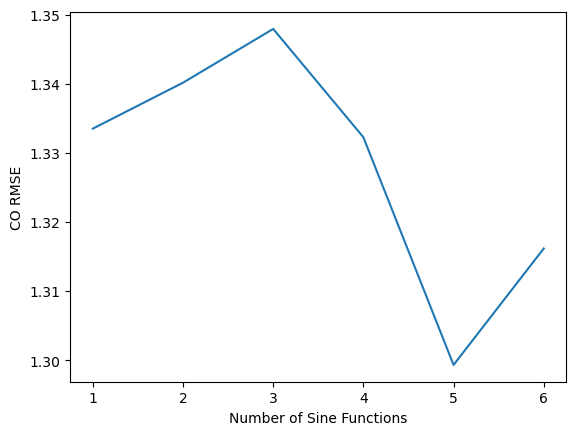

In [43]:
plt.plot(all_n_sine_functions, RMSEs)
plt.xlabel('Number of Sine Functions')
plt.ylabel('CO RMSE');

Using the list of RMSEs, find the index of the minimum values.  Use this to extract the number of sine functions, the RMSE, the shifts, the scales, and the W values from the best result.

In [45]:
def min_rmse_index(rmse_list):
    min_rmse = float('inf')
    min_index = 0
    for index, error in enumerate(rmse_list):
        if error < min_rmse:
            min_rmse = error
            min_index = index
    return min_index

test_index = min_rmse_index(RMSEs)
num_sine_func, test_rmse, test_best_shifts, test_best_scales, test_best_W = best_results[test_index]
test_index

4

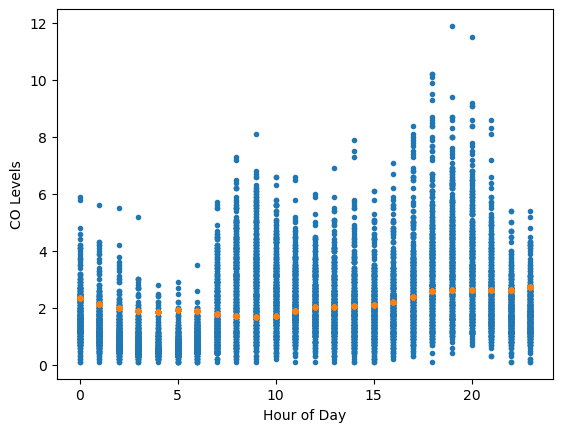

In [46]:
plt.plot(X, T, '.', label='Data')
plt.plot(X, Y, '.', label='Predictions');
plt.xlabel('Hour of Day')
plt.ylabel('CO Levels');

Make another similar plot, but this time evaluate and predict plotted values for 100 hour values linearly spaced from 0 to 23.

(100, 1)


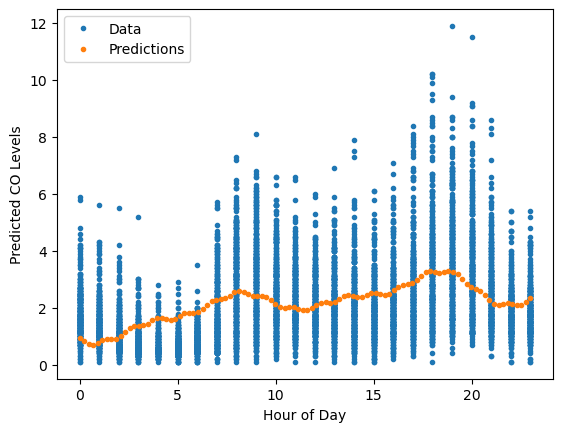

In [48]:
sample_x = np.linspace(0, 23, 100).reshape(-1, 1)
print(sample_x.shape)

# perform inference with best tested shifts, scales, weights (W)
Y = model(sine_transform(sample_x, test_best_shifts, test_best_scales), test_best_W)

plt.plot(X, T, '.', label='Data')
plt.plot(sample_x, Y, '.', label='Predictions')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted CO Levels')
plt.legend();

array([[0.        ],
       [0.23232323],
       [0.46464646],
       [0.6969697 ],
       [0.92929293],
       [1.16161616],
       [1.39393939],
       [1.62626263],
       [1.85858586],
       [2.09090909]])

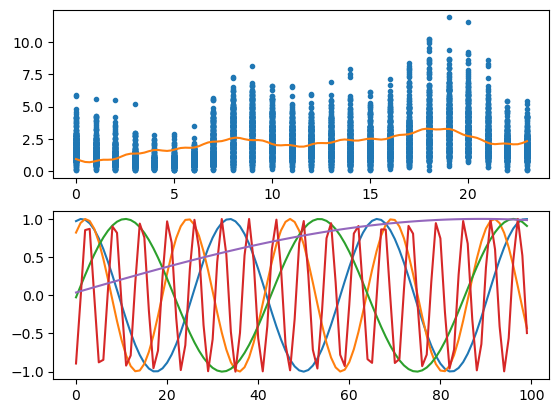

In [49]:
plt.subplot(2, 1, 1)

plt.plot(X, T, '.', label='Data')
xs_test = np.linspace(0, 23, 100).reshape(-1, 1)
Y = model(sine_transform(xs_test, test_best_shifts, test_best_scales), test_best_W)
plt.plot(xs_test, Y, label='Predictions')

plt.subplot(2, 1, 2)
plt.plot(sine_transform(xs_test, test_best_shifts, test_best_scales));
xs_test[:10]

### Analysis

The model's predictions using the best tested shifts, scales, and weights seemed to generalize pretty well here. However, you can tell the model's predictions for the decimal values tend to deviate from the trend of the surrounding values. The reason for this is likely because the model was trained using only the whole number hour values from 0-23. Here, we are testing it on linearly spaced values from 0-23 that contain decimal numbers, which the model has not seen before. I'd imagine utilizing the sine transformations of the input data helps the model generalize to these new values a little bit, but there is still a clear choppiness in the model's predictions of decimal values in the plot.

UPDATED SEPT. 6th

Write a new function named `search_and_plot_best` that takes arguments `X`, `T`, `list_of_n_sine_functions`, `shift_range`, `scale_range`, and `n_repetitions`, gets the results from one call to test_n_sine_functions and uses the results and the steps shown above to make the above two plots. The first plot will show T versus X as blue dots and the output of the best model in orange for 100 x values linearly spaced from 0 to 23. The second plot will show all of the sine function values for the best model for the same 100 x values. The code for producing both plots is demonstrated in the immediately above code cell.

Make it also print one line like 

    Best: 4 sines, RMSE 1.15

In [52]:
def search_and_plot_best(X, T, list_of_n_sine_functions, shift_range, scale_range, n_repetitions):
    """
    Params:
        X (numpy array): input data to model (hour of day)
        T (numpy array): target values to train against (CO levels)
        list_of_n_sine_functions (list/tuple/range): iterable collection of number of distinct sine calculations to generate
            for each sample in training dataset
        shift_range (list/tuple): collection w/ two elements that represent the low/high range of shift values to use
            in sine wave calculation
        scale_range (list/tuple): collection w/ two elements that represent the low/high range of scale values to use
            in sine wave calculation
        n_repetitions (int): number of training iterations to run

        Tests the model with the list of different sine functions given. The result with the lowest error and the parameters
        associated with it are returned from the search_best function. Then, those results are plotted.

        Returns:
            None
    """
    # test different sine functions and its variations
    results = test_n_sine_functions(X, T, list_of_n_sine_functions, shift_range, scale_range, n_repetitions)
    # search for the best test result
    best_result, all_n_sine_functions, RMSEs = search_best(results)
    n_sine_functions, rmse, best_shifts, best_scales, best_W = best_result

    plt.figure(1)
    plt.subplot(2, 1, 1)
    plt.plot(X, T, '.', label='Data')
    xs = np.linspace(0, 23, 100).reshape(-1, 1)
    Y = model(sine_transform(xs, best_shifts, best_scales), best_W)
    plt.plot(xs, Y, label='Predictions using Model with lowest RMSE')
    plt.xlabel('Hour of Day')
    plt.ylabel('Predicted CO Levels')
    plt.legend();

    plt.figure(2)
    plt.subplot(2, 1, 2)
    plt.plot(sine_transform(xs, best_shifts, best_scales));

    plt.figure(3)
    plt.subplot(2, 1, 2)
    plt.plot(all_n_sine_functions, RMSEs, label='Best RMSE')
    plt.xlabel('Number of Sine Functions')
    plt.ylabel('Lowest recorded RMSE');

    print('Best: {} sines, RMSE {}'.format(n_sine_functions, rmse))

def search_best(results):
    min_rmse = float('inf')
    min_index = 0
    all_n_sine_functions = []
    RMSEs = []
    for index, result in enumerate(results):
        all_n_sine_functions.append(result[0])
        RMSEs.append(result[1])
        if result[1] < min_rmse:
            min_rmse = result[1]
            min_index = index

    return results[min_index], all_n_sine_functions, RMSEs

### Variation 1
* `list_of_n_sine_functions` => 1, 5
* `shift_range` => -5-5
* `scale_range` => 0-2
* `n_repetitions` => 10

Best: 5 sines, RMSE 1.26328303533374


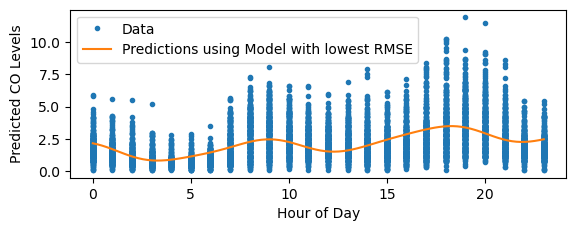

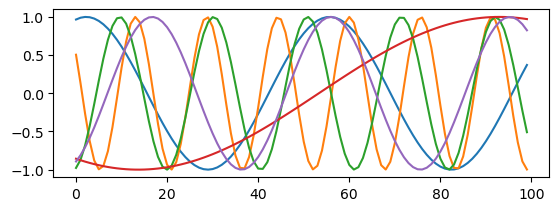

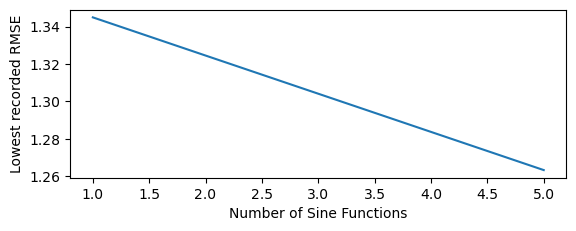

In [54]:
search_and_plot_best(X, T, [1, 5], [-5, 5], [0, 2], 10)

### Variation 2
* `list_of_n_sine_functions` => 1, 5
* `shift_range` => -5-5
* `scale_range` => **0-10**
* `n_repetitions` => **20**

Best: 5 sines, RMSE 1.3105424973605433


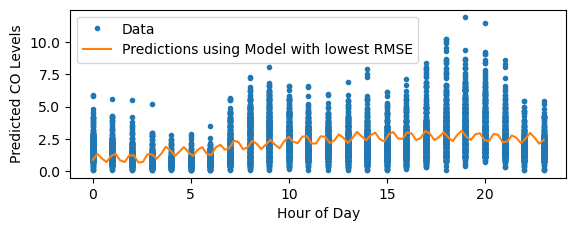

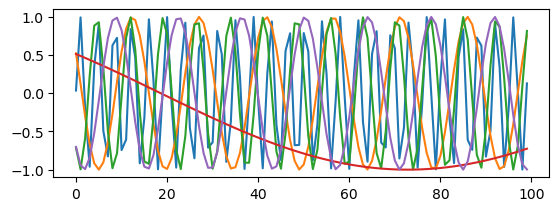

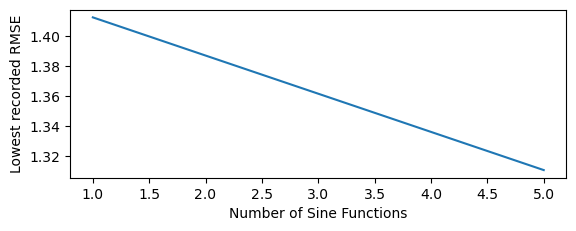

In [56]:
search_and_plot_best(X, T, [1, 5], [-5, 5], [0, 10], 20)

### Variation 3
* `list_of_n_sine_functions` => **5, 10, 15, 20, 25**
* `shift_range` => -5-5
* `scale_range` => **0-10**
* `n_repetitions` => **20**

Best: 20 sines, RMSE 1.1976758914235972


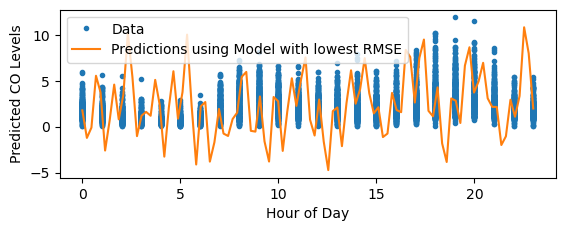

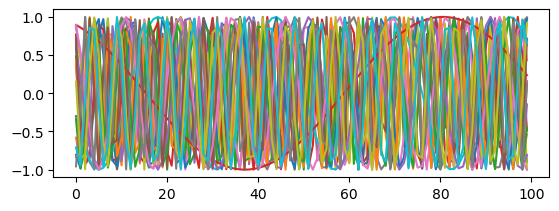

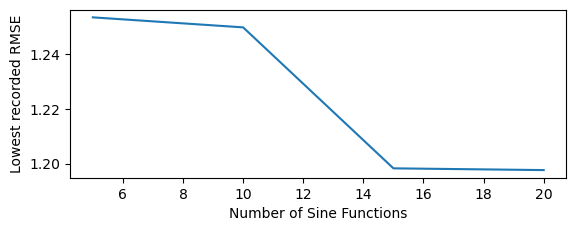

In [58]:
search_and_plot_best(X, T, range(5, 25, 5), [-5, 5], [0, 10], 20)

### Variation 4
* `list_of_n_sine_functions` => **5, 10, 15, 20, 25**
* `shift_range` => -5-5
* `scale_range` => **0-10**
* `n_repetitions` => **100**

Best: 20 sines, RMSE 1.1966482451299774


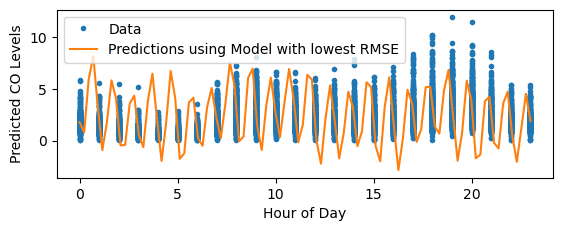

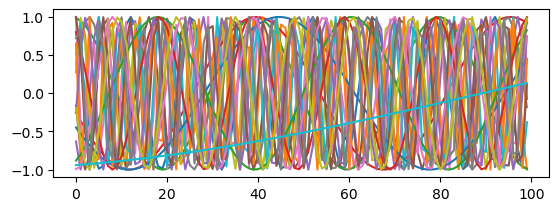

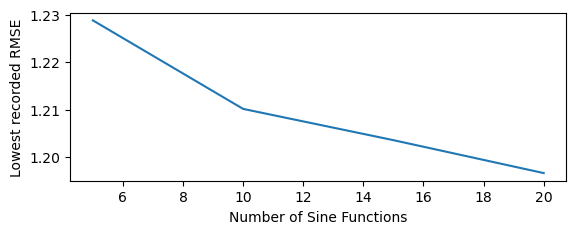

In [60]:
search_and_plot_best(X, T, range(5, 25, 5), [-5, 5], [0, 10], 100)

### Variation 5
* `list_of_n_sine_functions` => **1, 2, 3, 4, 5**
* `shift_range` => -5-5
* `scale_range` => **0-10**
* `n_repetitions` => **100**

Best: 4 sines, RMSE 1.2236303584440065


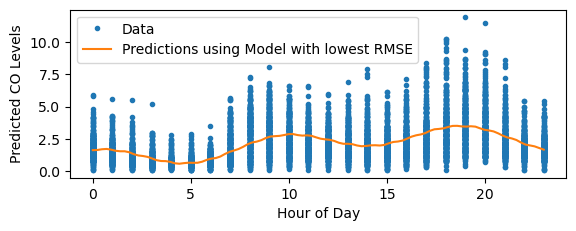

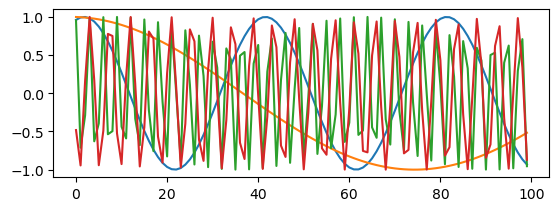

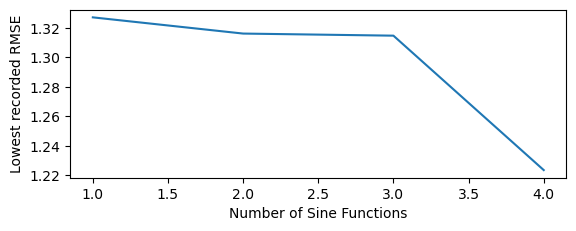

In [62]:
search_and_plot_best(X, T, range(1, 5), [-5, 5], [0, 10], 100)

### Variation 6
* `list_of_n_sine_functions` => **5, 10, 20, 30, 40, 50**
* `shift_range` => -5-5
* `scale_range` => **0-2**
* `n_repetitions` => **50**

Best: 50 sines, RMSE 1.1965987325658423


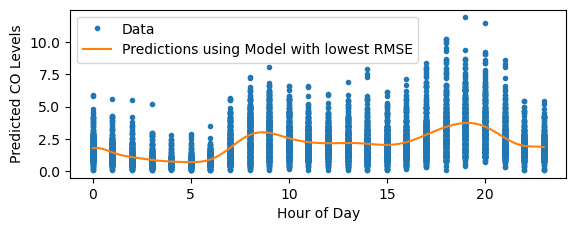

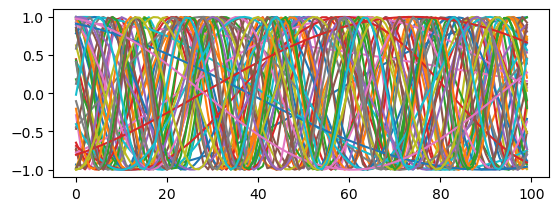

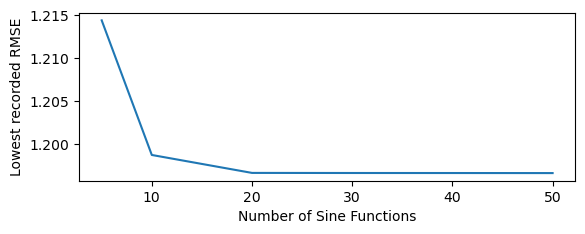

In [64]:
search_and_plot_best(X, T, [5, 10, 20, 30, 40, 50], [-5, 5], [0, 2], 50)

### Variation 7
* `list_of_n_sine_functions` => **5, 10, 20, 30, 40, 50**
* `shift_range` => -10-10
* `scale_range` => **-2-2**
* `n_repetitions` => **15**

Best: 50 sines, RMSE 1.1966050043868341


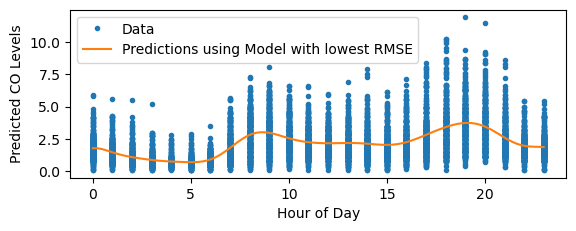

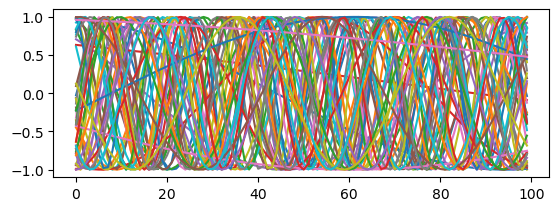

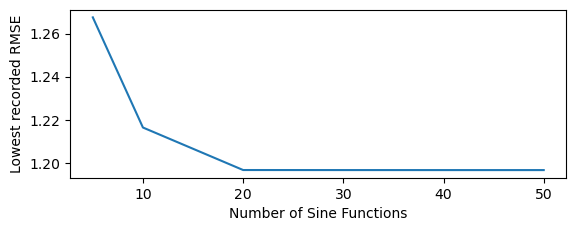

In [66]:
search_and_plot_best(X, T, [5, 10, 20, 30, 40, 50], [-10, 10], [-2, 2], 15)

### Variation 8
* `list_of_n_sine_functions` => **15, 20, 25, 30, 35**
* `shift_range` => **-50-50**
* `scale_range` => **-2-2**
* `n_repetitions` => **15**

Best: 35 sines, RMSE 1.1966115718590666


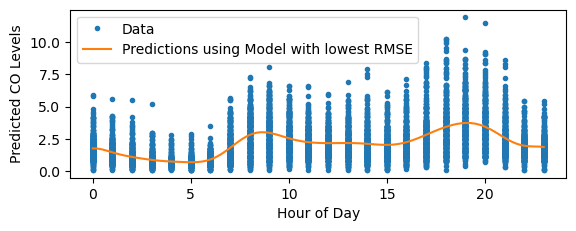

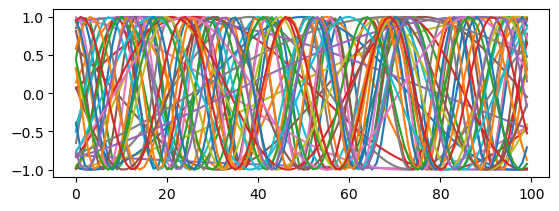

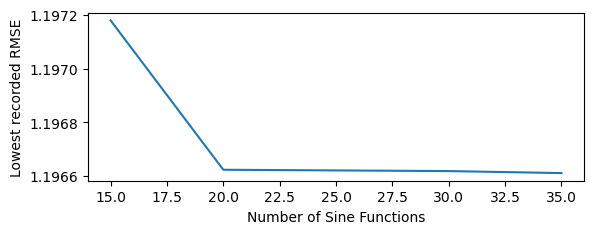

In [68]:
search_and_plot_best(X, T, [15, 20, 25, 30, 35], [-50, 50], [-2, 2], 15)


In the following markdown cell (or cells if you want to use more than one), describe the experiments you ran and the results.  Specifically you must write at least two sentences for each of the following items.

1. Did you find a pretty good model of the air quality data?

I found one that is okay, but I would not say that it is good. The lowest RMSE I have been able to achieve is ~1.1966. When I plot this model's predictions over the target data it is fit pretty well to the varying curvatures of the real CO levels. During the peak demand hours, there can be a pretty wide range of data so I've noticed the extremes (on either end) tend to be far away from where the model predicts. But overall, the model does a okay job of determining what looks to be an "average" CO level for a given time of day.

I would have liked to see the RMSE reach <1.1.

2. What range of `shifts` and `scales` did you find worked best?

I found that ranges of `scales`=[-2, 2] worked the best. Changing `shift_range` did not seem to have much effect on the RMSE. My first instinct was to increase both ranges, but that seemed to result in a worse RMSE in both cases. I was surprised to see that tightening the ranges actually resulted in a more accurate model/lower RMSE, at least in the case of `scales_range`.

My best RMSE came with a `shift_range` of [-50, 50].

I did notice that a wider `scale_range` resulted in a really choppy graph of the model's predictions. The graphs I saw with ranges upwards of [-10, 10] looked a little overfit. Tightening up the range resulted in a much smoother curve, which seems like it would generalize better.

3. How many repetitions of random `shifts` and `scales` worked well?

15 repetitions seemed to work pretty well. Any higher than that and the model would take pretty long to train and I did not notice an improvement in RMSE.

3. What values of `n_sine_functions` worked well, and what values did not work well?

I noticed the less sine functions, the worse the RMSE. This makes sense to me because the more sine functions we use, the more data the model has to train on. But increasing the number of sine functions to >20 did lower the RMSE slightly but it was very marginal. Looking at the graph of RMSE vs n_sine_functions you can see after 20 sine functions, the RMSE just flattens out.

I eventually settled on 20 sine functions. Any higher than that and there was not very much improvement.

However, I did notice that the number of sine functions had the largest impact on the RMSE.

4. What was the hardest part of this assignment?

For me, the hardest part was just getting familiar with all of the code in this notebook and the notebooks from class. There is a lot going on in these notebooks and I have to have a really good understanding of what its doing before I can start writing code myself. With python specifically, I have found its actually harder for me to fully grasp what a new codebase is doing because we generally do not use typing in Python compared to a language like C++.

I have found the best way for me to get a grasp of what a new python codebase is doing is to step through each individual function and start by writing out some docstrings indicating what all the input params are, their types, what the function returns, and ofcourse writing out in english what the business logic of the function is. Which is why you'll see I have added my own documentation throughout this assignment.

Once I did that, I was able to grasp what all the different helper functions were doing and how they were being called. From there, writing the code to automate the training process was pretty straightforward.

# Grading

Your notebook will be run and partially graded automatically. Test this grading process by first downloading [A1grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A1grader.zip) and unzip `A1grader.py` from it. After you have done that, run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as `A1solution.ipynb`, and then save this notebook.  Check in your `A1solution.ipynb` notebook when you are ready.

In [71]:
%run -i A1grader.py


Testing

    X = np.linspace(-10, 10, 50).reshape(-1, 1)
    T = np.sin(X) * np.sin(4 + 2 * X)
    z = test_variations(X, T, [-5, 5], [0, 3], 5, 10)


--- 10/10 points. z is correct length of 4.

--- 10/10 points. z[1] is correct length of 5.

--- 10/10 points. z[3] is correct shape (6, 1).
Additional tests...

--- Shifts z[1] and Scales z[2] are correctly equal in length.

--- Shifts z[1] is correct shape (5,).

--- Scales z[2] is correct shape (5,).

Testing

    X = np.linspace(-10, 10, 50).reshape(-1, 1)
    T = np.sin(X) * np.sin(4 + 2 * X)
    z = test_n_sine_functions(X, T, range(1, 5), [-5, 5], [0, 3], 10)


--- 10/10 points. z is correct length of 4 and z[1][0] is 2.

--- 10/10 points. z[2][2] is correct shape (3,).

--- 10/10 points. z[1][4] is correct shape (3,1).

Additional Tests...

 z[0] is correct length of 5.

Testing

    X = np.linspace(-10, 10, 50).reshape(-1, 1)
    T = np.sin(X) * np.sin(4 + 2 * X)
    list_of_n_sine_functions = [2, 4, 6, 8]
    test_n_sine_funct

# Extra Credit  (leave this section heading for us to find your extra credit work)

Replace the `sine_transform` function with one called `exp_transform` that transforms the `X` data using

$$  y(x) = \exp(-scale\; (X - shift)^2)
$$

Copy and paste the code used for the main experiment and edit it to use `exp_transform`.  Repeat the experiments now using your new code.  Remember to also write the descriptions and answers to the five questions.

Earn up to 2 extra credit points, depending on how complete your experiments are and how thorough your explanations are.



In [73]:
def exp_transform(X, shifts, scales):
    return np.exp(-scales * (X-shifts)**2)

In [74]:
def test_exp_variations(X, T, shift_range, scale_range, n_exp_functions, n_repetitions):
    """
    Args:
        X (numpy array): input data to model (hour of day)
        T (numpy array): target values to train against (CO levels)
        shift_range (list/tuple): collection w/ two ints that represent the low/high range of shift values to use
            in sine wave calculation
        scale_range (list/tuple): collection w/ two ints that represent the low/high range of scale values to use
            in sine wave calculation
        n_exp_functions (int): number of distinct exponential calculations to generate for each sample in training dataset
        n_repetitions (int): number of training iterations to run

        Iterates for n_repetitions. Each iteration, dervives n_exp_functions of random values for shifts b/t shift_range
        and scales between scale_range. These represent the inputs to the n_exp_functions that are calculated using the
        input data X.

        These transformed inputs are then passed into the model and the adam optimizer finds the best values for W. The
        error for each iteration is calculated and the data associated with the iteration with the lowest error is returned.

    Returns:
        Tuple(float, numpy aray, numpy array, numpy array): Tuple containing a float and 4 separate Numpy arrays.
            - float representing the lowest RMSE recorded
            - numpy array w/ the shift values used to attain the lowest RMSE
            - numpy array w/ the scale values used to attain the lowest RMSE
            - numpy array w/ the Weights used to attain the lowest RMSE
    """
    # Initialize variables with dummy data
    lowest_error = float('inf')
    best_shifts = np.zeros(n_exp_functions)
    best_scales = np.zeros(n_exp_functions)
    best_W = np.zeros((1 + X.shape[1], 1))

    for repetition in range(n_repetitions):
        shifts = np.random.uniform(shift_range[0], shift_range[1], n_exp_functions)
        scales = np.random.uniform(scale_range[0], scale_range[1], n_exp_functions)
        # transform with exponential function
        Xexponentials = exp_transform(X, shifts, scales)

        learning_rate = 0.01
        n_epochs = 1000
        W, error_sequence = adamw(model, Xexponentials, T, learning_rate, n_epochs)
        error = rmse(model(Xexponentials, W), T)
        if error < lowest_error:
            lowest_error = error
            best_shifts = shifts
            best_scales = scales
            best_W = W

    return lowest_error, best_shifts, best_scales, best_W

In [75]:
def test_n_exp_functions(X, T, list_of_n_exp_functions, shift_range, scale_range, n_repetitions):
    """
    Params:
        X (numpy array): input data to model (hour of day)
        T (numpy array): target values to train against (CO levels)
        list_of_n_exp_functions (list/tuple/range): iterable collection of number of distinct exponential calculations to generate
            for each sample in training dataset
        shift_range (list/tuple): collection w/ two elements that represent the low/high range of shift values to use
            in sine wave calculation
        scale_range (list/tuple): collection w/ two elements that represent the low/high range of scale values to use
            in sine wave calculation
        n_repetitions (int): number of training iterations to run

        For each num in list_of_n_exp_functions, use that num as the n_exp_functions and call test_variations with it and other input
        params.

        Store the results of each call to test_variations in a list, as a list. The result from test_variation will be the lowest error,
        shifts, scales, and weights within the range of the provided inputs that result in that lowest error.

    Returns:
        results (2D lists/arrays): list of lists; each individual list contains the results of a training session w/ following data:
            - n_exp_functions (int): num of exponential functions used to transform training data
            - rmse (float): lowest recorded rmse recorded during series of repetitions
            - list w/ the shift values used to attain the lowest RMSE
            - list w/ the scale values used to attain the lowest RMSE
            - list w/ the Weights used to attain the lowest RMSE
    """
    result = []
    for n in list_of_n_exp_functions:
        iteration = list(test_variations(X, T, shift_range, scale_range, n, n_repetitions))
        # insert n_exp_functions used as first element of iteration list
        iteration.insert(0, n)
        result.append(iteration)

    return result

In [76]:
def search_and_plot_best_exp(X, T, list_of_n_exp_functions, shift_range, scale_range, n_repetitions):
    """
    Params:
        X (numpy array): input data to model (hour of day)
        T (numpy array): target values to train against (CO levels)
        list_of_n_exp_functions (list/tuple/range): iterable collection of number of distinct exponential calculations to generate
            for each sample in training dataset
        shift_range (list/tuple): collection w/ two elements that represent the low/high range of shift values to use
            in sine wave calculation
        scale_range (list/tuple): collection w/ two elements that represent the low/high range of scale values to use
            in sine wave calculation
        n_repetitions (int): number of training iterations to run

        Tests the model with the list of different sine functions given. The result with the lowest error and the parameters
        associated with it are returned from the search_best function. Then, those results are plotted.

        Returns:
            None
    """
    # test different sine functions and its variations
    results = test_n_exp_functions(X, T, list_of_n_exp_functions, shift_range, scale_range, n_repetitions)
    # search for the best test result
    best_result, all_n_sine_functions, RMSEs = search_best(results)
    n_exp_functions, rmse, best_shifts, best_scales, best_W = best_result

    plt.figure(1)
    plt.subplot(2, 1, 1)
    plt.plot(X, T, '.', label='Data')
    xs = np.linspace(0, 23, 100).reshape(-1, 1)
    Y = model(sine_transform(xs, best_shifts, best_scales), best_W)
    plt.plot(xs, Y, label='Predictions using Model with lowest RMSE')
    plt.xlabel('Hour of Day')
    plt.ylabel('Predicted CO Levels')
    plt.legend();

    plt.figure(2)
    plt.subplot(2, 1, 2)
    plt.plot(exp_transform(xs, best_shifts, best_scales));

    plt.figure(3)
    plt.subplot(2, 1, 2)
    plt.plot(all_n_sine_functions, RMSEs, label='Best RMSE')
    plt.xlabel('Number of Exponential Functions')
    plt.ylabel('Lowest recorded RMSE');

    print('Best: {} exponentials, RMSE {}'.format(n_exp_functions, rmse))


### Exponential Variation 1
* `n_exp_functions` -> 3, 5, 10, 15
* `shift_range` -> [-10, 10]
* `scale_range` -> [-2-2]
* `n_repetitions` -> 15

Best: 15 exponentials, RMSE 0.336679464460105


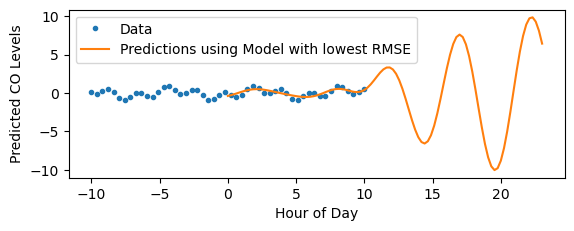

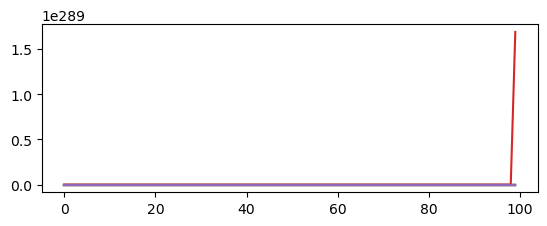

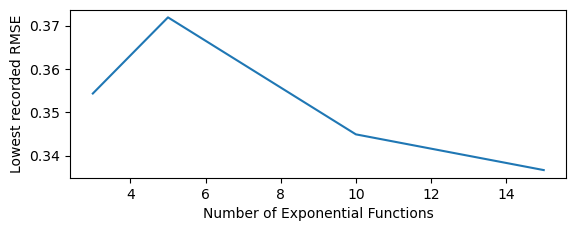

In [78]:
search_and_plot_best_exp(X, T, [3, 5, 10, 15], [-10, 10], [-2, 2], 15)

### Exponential Variation 2
* `n_exp_functions` -> **15, 20, 25**
* `shift_range` -> **[-5, 5]**
* `scale_range` -> **[0-2]**
* `n_repetitions` -> 15

Best: 25 exponentials, RMSE 0.32833397351352056


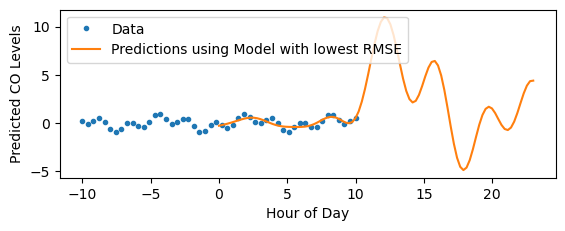

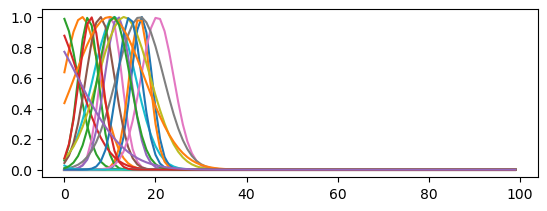

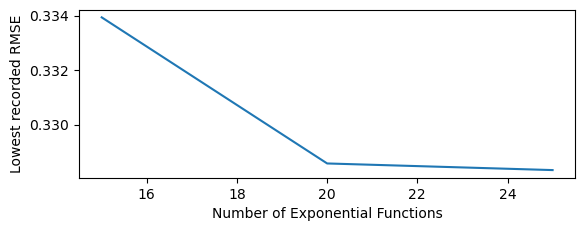

In [80]:
search_and_plot_best_exp(X, T, [15, 20, 25], [-5, 5], [0, 2], 15)

### Exponential Variation 3
* `n_exp_functions` -> **25, 30, 35, 40, 45, 50**
* `shift_range` -> **[-5, 5]**
* `scale_range` -> **[0-2]**
* `n_repetitions` -> 15

Best: 45 exponentials, RMSE 0.325987100458883


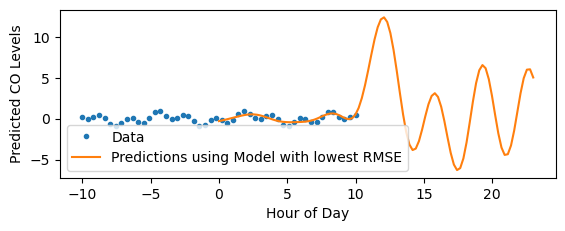

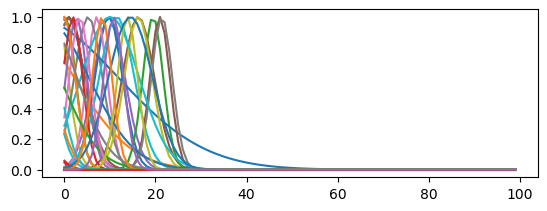

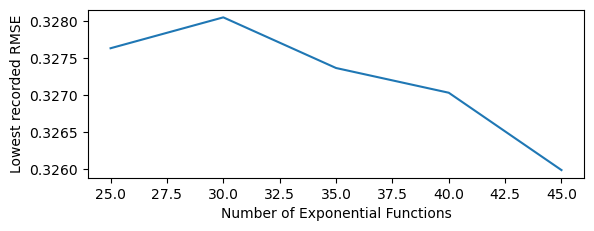

In [82]:
search_and_plot_best_exp(X, T, range(25, 50, 5), [-5, 5], [0, 2], 15)

### Exponential Variation 4
* `n_exp_functions` -> **25, 30, 35, 40, 45, 50**
* `shift_range` -> **[-50, 50]**
* `scale_range` -> **[0-2]**
* `n_repetitions` -> 15

Best: 40 exponentials, RMSE 0.32612263095930444


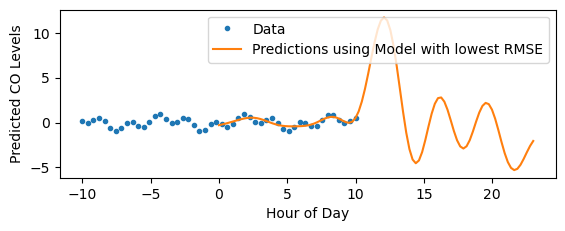

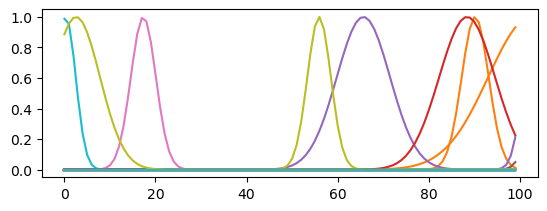

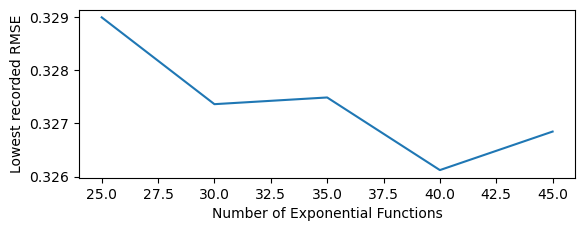

In [84]:
search_and_plot_best_exp(X, T, range(25, 50, 5), [-50, 50], [0, 2], 15)

### Exponential Variation 5
* `n_exp_functions` -> **25, 30, 35, 40, 45, 50**
* `shift_range` -> **[-5, 5]**
* `scale_range` -> **[0-2]**
* `n_repetitions` -> **100**

Best: 45 exponentials, RMSE 0.3255643506092424


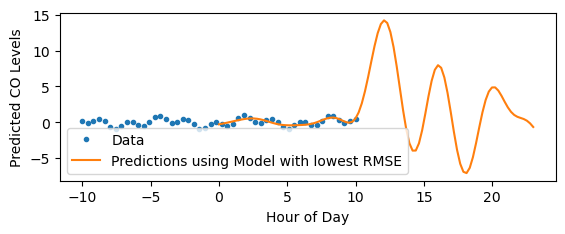

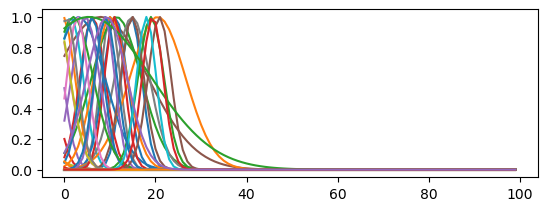

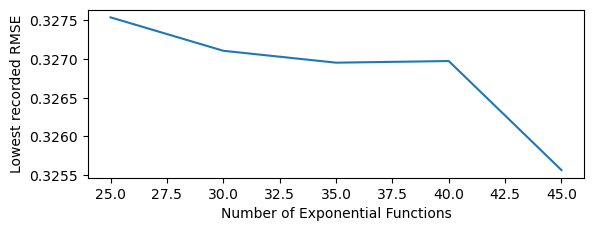

In [86]:
search_and_plot_best_exp(X, T, range(25, 50, 5), [-5, 5], [0, 2], 100)

### Exponential Variation 6
* `n_exp_functions` -> **25, 30, 35, 40, 45, 50**
* `shift_range` -> **[-5, 5]**
* `scale_range` -> **[0-3]**
* `n_repetitions` -> **15**

Best: 35 exponentials, RMSE 0.0018379133833861902


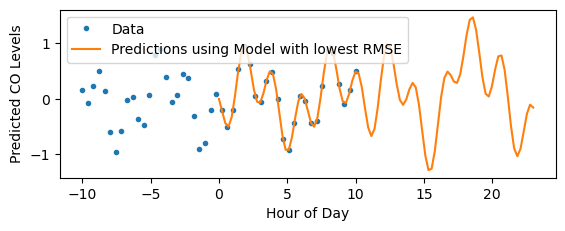

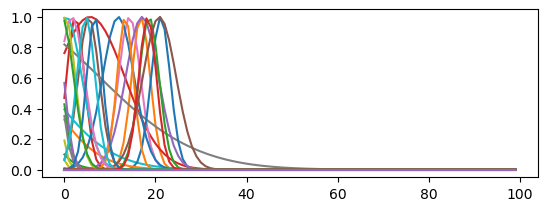

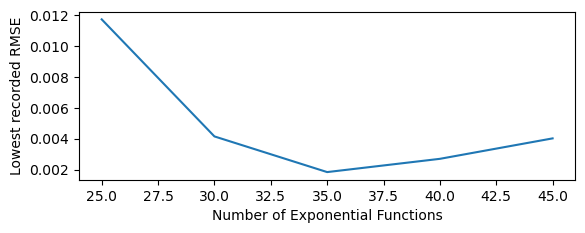

In [88]:
search_and_plot_best_exp(X, T, range(25, 50, 5), [-5, 5], [0, 3], 15)

In the following markdown cell (or cells if you want to use more than one), describe the experiments you ran and the results.  Specifically you must write at least two sentences for each of the following items.

1. Did you find a pretty good model of the air quality data?

I found a model that was pretty similar to the sine methodolgy in terms of RMSE. The lowest RMSE I've seen witht he exponential model is ~1.1954 which is right around where the sine model was

2. What range of `shifts` and `scales` did you find worked best?

Similar to before, I did not notice the `shift_range` change the RMSE very much. The `scale_range` also had a pretty big impact on the shape of the graph of the model's predictions. Just like before, a wider range resulted in a much more choppy graph. I found a range of [0, 3] for `scale_range` was a good balance between a smooth curve while still following the ups/downs of the training data pretty closely.

I settled on a `shift_range` of [-5, 5], that is the range I used to achieve the lowest RMSE witht the exponential model.


3. How many repetitions of random `shifts` and `scales` worked well?

Again around 15 repetitions worked well. Any more than that and there was no improvement, plus the model would take much longer to train.

4. What values of `n_exp_functions` worked well, and what values did not work well?

`n_exp_functions` of 35 seemed to work the best. In a few iterations, the RMSE increased significantly with `n_exponential_functions` higher than 35. This was surprising and was not the case with the sine functions. The sine functions RMSE continued to decrease, albeit marginally, the more sine functions we used.

5. What was the hardest part of this assignment?

Since we are copying and re-using functions that were defined before for the sine model, I'd say the hardest part of the extra credit was altering those to work with the new exponential model. Going through them and making sure we replace any reference to the sine specific section with the new relevant exponential counterpart to ensure we are not accidentally referencing any incorrect values was the hardest. Ideally, I think we'd design these functions to be more modular so that they work with either the sine or exponential function.